# Trabajo Práctico 1 
### Clasificación sobre datos simulados. 

## Introducción
Para este trabajo, hemos creado una función generadora de minions. Sobre cada minion, hemos medido 200 características que representan habilidades que poseen en distintas tareas (relacionadas al Mal).  

El doctor Nefario ha ideado una fórmula para determinar si un minion es o no apto para concretar su plan para conquistar el mundo. De esta manera ha etiquetado más de 500 minions. Lamentablemente, ha perdido dicha fórmula y necesita seguir decidiendo si nuevos minions son o no aptos para su macabro plan.

Es por esto que nuestro objetivo será construir clasificadores que estimen lo mejor posible la probabilidad de que nuevos minions sean o no aptos para concretar el plan de conquista y así facilitarle las cosas al doctor Nefario.

Por otra parte, ya que el doctor Nefario tuvo problemas con equipos que sobreestiman sus resultados, decidió guardarse varias etiquetas extra que no compartirá con nadie, y que luego utilizará para elegir al mejor equipo, al cual contratará para (de una vez por todas) conquistar el mundo. 


En concreto:

Tendrán disponible una matriz de datos $X$ de $500$ filas en donde cada fila $x^{(i)}$ representa un vector de $200$ características de cada instancia. Es decir, $\textbf{x}^{(i)} = x_1^{(i)}, \dots, x_{200}^{(i)}$ con $i$ entre $1$ y $500$. Además, tendrán y, un vector de $500$ posiciones con dos posibles valores: $True$ y $False$. 

Por otra parte, tendrán disponibles más instancias de evaluación $X_{competencia}$ sin las respectivas etiquetas que utilizaremos para evaluar sus resultados. 



In [1]:
# PREAMBULOS
%matplotlib inline

SEED = 1234

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from IPython.display import display, HTML
from time import time

import numpy as np
np.set_printoptions(precision=4)
np.random.seed(SEED)

import pandas as  pd
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 15)

pd.set_option('precision', 4)

import matplotlib.pyplot as plt

import seaborn as sns

import sklearn.ensemble
import sklearn.naive_bayes
import sklearn.svm

#Para el ejercicio 2
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, roc_curve

import sklearn.model_selection
from scipy.stats import randint as sp_randint

# Ejercicio Opcional
from arbolDeDecision import MiClasificadorArbol
from arbolDeDecision import imprimir_arbol

In [2]:
# Carga de datos
X = pd.read_csv("X.csv", index_col="index")
y = pd.read_csv("y.csv", index_col="index", dtype=int)  # Cargamos los valores booleanos (True y False)
                                                        # como números (1 y 0) para facilitar el manejo luego.     
X_competencia = pd.read_csv("X_competencia1.csv", index_col="index")
y_competencia_ejemplo = pd.read_csv("y_competencia_ejemplo.csv", index_col="index")

display(X)
display(y)

#display(len(X_train))
#display(len(X_test))

#pd.plotting.scatter_matrix(X, c=y, s=80, figsize=(15, 8), marker='o', alpha=.8);

# Descomentar si quieren ver los datos para la competencia:
# display(X_competencia) 
# display(y_competencia_ejemplo)

,0,1,2,3,4,5,6,...,193,194,195,196,197,198,199
index,,,,,,,,,,,,,,,
0,1.4914,0.1644,1.2315,1.2429,1.5576,0.0455,0.1302,...,-1.1983,-0.0118,1.5375,-0.7727,-0.1401,2.0871,-0.8312
1,-0.2749,0.2780,-1.3108,0.6801,-0.5503,0.6359,-0.4478,...,1.2190,-0.3190,-0.6446,-0.0061,-1.2374,-1.3291,-1.3265
2,-0.2243,-0.5710,-0.2712,-0.1328,-1.0045,0.9315,-1.4507,...,0.9459,0.1430,-0.1989,-0.0393,-0.5866,2.2507,1.4925
3,0.5853,-0.8532,-0.2723,-0.5493,-2.9824,-0.1697,-0.0430,...,1.6488,-0.7363,-0.8866,-1.2717,-0.1493,0.2007,-1.4820
4,-1.4155,1.4187,0.6027,-0.7993,0.2939,-0.1796,-0.7140,...,1.1314,-0.4230,-0.2685,0.3045,-1.2245,-1.9421,1.5186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.2516,0.9375,-1.1980,0.4577,0.9287,0.5373,0.2476,...,0.5829,-0.5494,0.4607,1.2182,0.1025,3.0034,-0.0344
496,0.6246,-1.0590,0.9491,0.2687,0.6610,-1.6657,0.3982,...,-0.1075,0.8993,-0.4229,0.3977,-0.0808,-1.7054,-0.4786
497,0.2677,0.1802,0.7154,0.3542,-0.9023,-1.7792,-0.0121,...,0.8491,0.7469,0.2071,-1.0090,0.3317,-1.7513,-0.5397


,output
index,
0,0
1,0
2,0
3,0
4,1
...,...
495,1
496,0
497,1


## Ejercicio 1

### Separación de datos

Contarán con una cantidad limitada de datos, por lo cual es importante tomar una buena decisión en el momento de empezar a utilizarlos. En este punto pedimos que evalúen cómo separar sus datos para desarrollo y para evaluación tomando en cuenta la competencia. 

Para poder tomar los datos de desarrollo y evaluación, decidimos utilizar la varianza de los atributos como una primera manera de discriminar los datos.Notamoss que la varianza de los datos era muy igual y muy pocos "minions" tenían una varianza "grande" (mayor a 1.2). Al momento de analizar los datos, descubrimos que si bien estábamos tomando una muestra del 10% de la población, esta muestra de evaluación, no contenía la misma proporción que la población total de datos. De esta manera, decidimos cambiar la forma de separar los datos y decidimos tomar un 10% de los datos positivos y un 10% de los datos negativos. Para poder hacer esto, tomamos la cantidad de datos Positivos y negativos, guardando en 2 listas, los indices de donde se encuentran. Una vez hecho esto, tomamos de forma random
los indices correspondientes a los datos positivos y los datos negativos (guardándolos en una lista random_values
). Una vez que guardamos los indices en una lista general, se avanza con la toma de los "minions" de desarrollo y de evaluación. Si el indice del minion se encuentra en la lista random_values, se toma ese "minion" como un "minion" de evaluación, de lo contrario, se lo toma como un "minion" de desarrollo.

### Correcciones para le RTP
Cambiamos nuestra implementacion de la separacion de los datos por **train_test_split**. Ademas usamos el parametro **stratify** que se encarga de hacer lo mismo que haciamos antes.


'#### Data Split ####'

0    244
1    206
Name: output, dtype: int64

0    27
1    23
Name: output, dtype: int64

'#### 0/1 frequency ratio ####'

'## dev ##'

1.1844660194174756

'## eval ##'

1.173913043478261

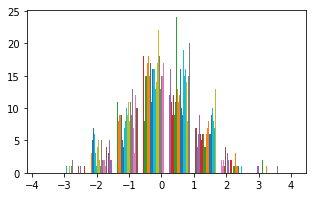

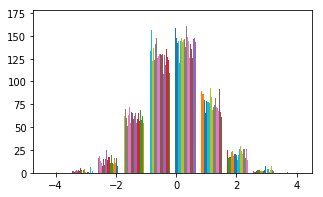

In [3]:
# EJERCICIO 1. 
from sklearn.model_selection import train_test_split
X_dev, X_eval, y_dev, y_eval = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.10)

display("#### Data Split ####")
display(y_dev['output'].value_counts())
display(y_eval['output'].value_counts())

display("#### 0/1 frequency ratio ####")

display("## dev ##")
display(y_dev['output'].value_counts()[0] / y_dev['output'].value_counts()[1])

display("## eval ##")
display(y_eval['output'].value_counts()[0] / y_eval['output'].value_counts()[1])

#Distribucion de los X de evaluacion
plt.figure(figsize=(5, 3))
plt.hist(np.array(X_eval))
plt.show()

#Distribucion de los X de entrenamiento
plt.figure(figsize=(5, 3))
plt.hist(np.array(X_dev))
plt.show()

## Ejercicio 2

### Construcción de modelos

Para este punto, la tarea consiste en construir y evaluar modelos de tipo árbol de decisión, de manera de obtener una estimación realista de la performance de los mismos. 

1. Entrenar un árbol de decisión con altura máxima 3 y el resto de los hiperparámetros en default. 
2. Estimar la performance del modelo utilizando K-fold cross validation con K = 5, con las métricas “Accuracy” y “ROC AUC”. Para ello, se pide medir la performance en cada partición tanto sobre el fold de validación como sobre los folds de entrenamiento. Luego, completar la primera tabla.
3. Entrenar árboles de decisión para cada una de las siguientes combinaciones y completar la segunda tabla.

----

**EJERCICIO EXTRA: Usar la implementación de árboles de decisión que realizaron para la guía de ejercicios de la materia. Adaptarla para que cumpla con la interfaz requerida por sklearn, asegurarse de que funcione con variables continuas y reproducir las tablas anteriores.**


### Correciones para el RTP
Ahora usamos predict_proba para calcular el score **AUC_ROC**.

----

In [4]:
### Arbol de sklearn ###
arbol = DecisionTreeClassifier(max_depth=3)

#######################
### Ejercicio Extra ###
#######################

# Descomentar para usar este arbol 
#arbol = MiClasificadorArbol(max_depth=3)

In [5]:
from arbolDeDecision import imprimir_arbol

accuracies_training = []
accuracies_validation = []
aucs_training = []
aucs_validation = []

X_dev_np = np.array(X_dev)
y_dev_np = np.array(y_dev).ravel()

X_eval_np = np.array(X_eval)
y_eval_np = np.array(y_eval).ravel()

arbol.fit(X_dev_np, y_dev_np)

def get_positive_class_probabilities(arr):
    arr_aux = []
    for entry in arr:
        arr_aux.append(entry[1])
    return arr_aux

def get_accuracy(y_pred, y_eval_np):
    return np.mean(y_pred == y_eval_np)
    
def show_prediction_accuracy(y_pred, y_eval_np, x_eval_np):
    print("Predicciones sobre el test set:\n {}".format(y_pred))
    print("Score sobre el test set: {:.2f}".format(np.mean(y_pred == y_eval_np))) # A mano
    print("Score sobre el test set: {:.2f}".format(arbol.score(x_eval_np, y_eval_np))) # Usando el método score.

#Generamos los 5 folds
kf = KFold(n_splits=5)

accuracy_train      = []
accuracy_validation = []
roc_train      = []
roc_validation = []

for train_index, test_index in kf.split(X_dev_np):
    #print("TRAIN:", train_index, "TEST:", test_index)
    kf_X_train, kf_X_test = X_dev_np[train_index], X_dev_np[test_index]
    kf_y_train, kf_y_test = y_dev_np[train_index], y_dev_np[test_index]
    
    # Entrenamos el arbol con el fold actual
    arbol.fit(kf_X_train, kf_y_train)
    
    # Testeamos contra el fold de test para calcular accuracy
    kf_y_pred     = arbol.predict(kf_X_test)
    kf_y_pred_dev = arbol.predict(kf_X_train)
        
    # Calculamos accuracy
    accuracy_validation.append(get_accuracy(kf_y_pred, kf_y_test) )
    accuracy_train.append(get_accuracy(kf_y_pred_dev, kf_y_train) )

    # Testeamos contra el fold de test para calcular el score roc
    kf_y_pred_proba     = arbol.predict_proba(kf_X_test)
    kf_y_pred_dev_proba = arbol.predict_proba(kf_X_train)
    
    # Calculamos roc score
    roc_train.append(sklearn.metrics.roc_auc_score(kf_y_train, get_positive_class_probabilities(kf_y_pred_dev_proba)))
    roc_validation.append(sklearn.metrics.roc_auc_score(kf_y_test, get_positive_class_probabilities(kf_y_pred_proba)))
    
df = pd.DataFrame(index=range(1,6))
df.index.name = "Permutación"
                  
df["Accuracy (training)"]   = accuracy_train      # cambiar por accuracies_training
df["Accuracy (validación)"] = accuracy_validation # cambiar por accuracies_validation
df["AUC ROC (training)"]    = roc_train           # cambiar por aucs_training
df["AUC ROC (validación)"]  = roc_validation      # cambiar por aucs_validation

display(HTML("<h3> TABLA 1 </h3>"))
display(df)

# Descomentar las siguientes líneas para graficar el resultado
# df.plot(kind="bar")
# plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
# plt.show()

,Accuracy (training),Accuracy (validación),AUC ROC (training),AUC ROC (validación)
Permutación,,,,
1,0.8111,0.7000,0.8783,0.7258
2,0.8278,0.6222,0.8741,0.7122
3,0.8222,0.6556,0.8740,0.7103
4,0.8278,0.7222,0.8752,0.7605
5,0.8028,0.6000,0.8571,0.7195


In [6]:
resultados_training   = []
resultados_validation = []

########################################################

np.random.seed(SEED)
for criterio in ["gini", "entropy"]:
     for altura in [3, 5, None]:
        
        arbol = DecisionTreeClassifier(max_depth=altura, criterion=criterio)
        arbol.fit(X_dev_np, y_dev_np)
        
        #Entrenamiento
        y_pred = arbol.predict_proba(X_dev_np)
        resultados_training.append( sklearn.metrics.roc_auc_score(y_dev_np, get_positive_class_probabilities(y_pred)))
        
        #Validacion
        y_pred = arbol.predict_proba(X_eval_np)
        resultados_validation.append( sklearn.metrics.roc_auc_score(y_eval_np, get_positive_class_probabilities(y_pred)))

#########################################################

df = pd.DataFrame(index=range(0,6))

df["Altura máxima"] = [3, 5, "Inifinito"] * 2
df["Criterio de evaluación de corte"] = ["Gini"] * 3 + ["Ganancia de Información"] * 3
df["AUC ROC promedio (training)"]   = resultados_training# reemplazar por resultados_training
df["AUC ROC promedio (validación)"] = resultados_validation # reemplazar por resultados_validation

   
display(HTML("<h3> TABLA 2 </h3>"))
display(df)

,Altura máxima,Criterio de evaluación de corte,AUC ROC promedio (training),AUC ROC promedio (validación)
0,3,Gini,0.8604,0.7303
1,5,Gini,0.9527,0.5523
2,Inifinito,Gini,1.0000,0.6932
3,3,Ganancia de Información,0.8388,0.7287
4,5,Ganancia de Información,0.9437,0.7689
5,Inifinito,Ganancia de Información,1.0000,0.6312


### Ejercicio Extra
Para esto tomamos como base el arbol del notebook 4 y lo importamos a un archivo .py para usarlo. 

**Para probarlo, simplemente descomentar la linea del principio de este ejercicio donde se crea el arbol de decision**.

Cambios:
    - En las preguntas comparar por >= para tomar espacios continuos.
    - Agregamos la entropia como calculo de ganancia
    - Agregamos los parametros de profundidad maxima y seleccion de criterio para el arbol. 

### Correcciones para el RTP

Agregamos la posibilidad de usar **predict_proba** para calcular el score **AUC_ROC** y arreglamos los problemas de performance, esto lo hicimos .... COMPLETAR

Pudimos ver que el score obtenido por nuestro arbol es bastante menor en la mayoria de los casos pero en algunos se acerca bastante al del implementado en sklearn.

## Ejercicio 3: Comparación de algoritmos


Se pide explorar distintas combinaciones de algoritmos de aprendizaje e hiperparámetros, de manera de buscar una performance óptima. Para este ejercicio es necesario que evalúen posibilidades utilizando la técnica de Grid Search. Como métrica de performance, usar siempre el área bajo la curva (AUC ROC) resultante de 5-fold cross-validation. 

Algoritmos a probar: KNN, árboles de decisión, LDA, Naive Bayes y SVM. Hiperparámetros: Revisar la documentación de cada uno para la búsqueda de combinaciones prometedoras.  

Se pide generar un reporte que contenga: 

1. Una descripción de las distintas combinaciones consideradas y su performance asociada (las que consideren relevantes, con al menos la mejor combinación para cada algoritmo). 

1. Una breve explicación de los factores que creen que produjeron dicho resultado. 

En este punto evaluaremos tanto los hiperparámetros elegidos como las conclusiones relacionadas a por qué piensan que ciertos algoritmos funcionan mejor que otros para estos datos. 



----

**EJERCICIO EXTRA**: Utilizar RandomizedSearchCV con rangos de parámetros que contengan a los utilizados en el GridSearch. Analizar si se encontraron mejores combinaciones de parámetros que no hayan sido tenidas en cuenta con el GridSearch y cuál fue la diferencia de tiempo de ejecución. 

----

In [7]:
import time

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

##############################################
################# Auxiliares #################
##############################################

def top_resultados(grid, top=5):
    print("Top {} combinaciones".format(top))
    df = pd.DataFrame(grid.cv_results_["params"])
    df["mean_score_validation"] = grid.cv_results_["mean_test_score"]
    df["mean_score_training"] = grid.cv_results_["mean_train_score"]
    display(df.sort_values(by="mean_score_validation", ascending=False).head(top))

def bot_resultados(grid, bot=5):
    print("Bot {} combinaciones".format(bot))
    df = pd.DataFrame(grid.cv_results_["params"])
    df["mean_score_validation"] = grid.cv_results_["mean_test_score"]
    df["mean_score_training"] = grid.cv_results_["mean_train_score"]
    display(df.sort_values(by="mean_score_validation", ascending=True).head(bot))
    
def correr_y_mostrar(estimator, parameters, folds, top):
    grid = GridSearchCV(estimator, parameters, cv=folds, scoring='roc_auc')
    time_before = time.time()
    grid.fit(X_dev_np, y_dev_np)
    time_after = time.time()
    top_resultados(grid, top)
    bot_resultados(grid, top)
    runtime = (time_after - time_before) * 1000.0 
    return (runtime, grid)

# Para usar en caso de tener probabilidades a priori
priors = [(0.1,0.9),(0.2,0.8),(0.3,0.7),(0.4,0.6),(0.5,0.5),(0.6,0.4),(0.7,0.3),(0.8,0.2),(0.9,0.1)]

### Decision Trees

Para este algoritmo decidimos usar solo los atributos criterio y max_depth, ya que son los mas simples a la hora de explicar como se comportan y como afectas a los datos de entrenamiento.

Sin embargo, al hacer algunas pruebas nos encontramos con otro parametro que nos parecio interesante, a continuacion hacemos los analisis en los dos casos (solo con criterio y max_depth | agregando el nuevo parametro).

In [8]:
parametersDecisionTree = {
    'criterion':['entropy','gini'],
    'max_depth':range(1,51)
}

(tiempo_decision_tree, grid_decision_tree) = correr_y_mostrar(
    DecisionTreeClassifier(),
    parametersDecisionTree,
    5,
    5
)

parametersDecisionTree2 = {
    'criterion':['entropy','gini'],
    'max_depth':range(1,51),
    'min_samples_split':range(2, 30)
}

(tiempo_decision_tree_2, grid_decision_tree_2) = correr_y_mostrar(
    DecisionTreeClassifier(),
    parametersDecisionTree2,
    5,
    5
)

Top 5 combinaciones


,criterion,max_depth,mean_score_validation,mean_score_training
1,entropy,2,0.7531,0.8061
2,entropy,3,0.7388,0.8718
3,entropy,4,0.7295,0.9267
51,gini,2,0.7287,0.8089
52,gini,3,0.7253,0.8726


Bot 5 combinaciones


,criterion,max_depth,mean_score_validation,mean_score_training
55,gini,6,0.5851,0.9925
56,gini,7,0.5874,0.9963
57,gini,8,0.5955,0.9979
89,gini,40,0.6070,1.0000
91,gini,42,0.6083,1.0000


Top 5 combinaciones


,criterion,max_depth,min_samples_split,mean_score_validation,mean_score_training
139,entropy,5,29,0.7570,0.9472
559,entropy,20,29,0.7568,0.9539
867,entropy,31,29,0.7566,0.9538
974,entropy,35,24,0.7561,0.9711
137,entropy,5,27,0.7555,0.9503


Bot 5 combinaciones


,criterion,max_depth,min_samples_split,mean_score_validation,mean_score_training
1540,gini,6,2,0.5763,0.9927
1570,gini,7,4,0.5884,0.9960
1574,gini,7,8,0.5891,0.9955
1596,gini,8,2,0.5920,0.9980
1597,gini,8,3,0.5970,0.9987


### Solo con dos parametros

A priori se puede ver que los mejores vs peores resultados tienen profundidades maximas bastante distintas(A excepcion del peor elemento con altura 6, suponemos que fue una muy mala muestra que justo dio ese resultado). Entre los mejores arboles en promedio no superan los 5 niveles, mientras que en los peores suele estar alrededor del 14/15.

Una cosa importante a remarcar es que en los peores arboles, el score del set de entrenamiento es bastante alto (y 1 en varios casos), mientras que en los mejores este baja un poco. Esto se da por la tendencia a overfittear  data rapidamente de estos arboles a medida que aparecen mas niveles (Las hipotesis que toma se vuelven casos mas particulares).

Por como se dan los resultados pareciera que la entropia funciona un poco mejor que gini como criterio, pero suponemos que esto no necesariamente es asi en el caso general. 

### Agregando min_samples_split

Podemos ver que con min_samples_split el arbol se limita a cortar un nodo si hay al menos esa cantidad de samples que caen en el. 

Teniendo lo anterior en cuenta podemos observar que los arboles que dieron los mejores resultados fueron los que tuvieron mayor profundidad y mayor cantidad de samples como minimo para separar un nodo. Nuestra suposicion es que al ser relativamente alta la cantidad minima de splitteo, esto evita overfittear sobre casos no muy normales en los datos y obtener profundidad sobre informacion que es relevante. Pero manteniendo un limite a la hora de crear hipotesis demasiado particulares.

### Naive Bayes

En este estimador solo tomamos las probabilidades a priori de las clases.

In [9]:
parametersNaiveBayes = {
    'priors':priors
}

(tiempo_bayes, grid_bayes) = correr_y_mostrar(
    GaussianNB(), 
    parametersNaiveBayes, 
    5, 
    5
)

Top 5 combinaciones


,priors,mean_score_validation,mean_score_training
8,"(0.9, 0.1)",0.8222,0.8619
0,"(0.1, 0.9)",0.8221,0.8616
1,"(0.2, 0.8)",0.8221,0.8615
2,"(0.3, 0.7)",0.8220,0.8616
3,"(0.4, 0.6)",0.8220,0.8618


Bot 5 combinaciones


,priors,mean_score_validation,mean_score_training
4,"(0.5, 0.5)",0.8218,0.8620
5,"(0.6, 0.4)",0.8218,0.8620
6,"(0.7, 0.3)",0.8219,0.8620
7,"(0.8, 0.2)",0.8219,0.8619
2,"(0.3, 0.7)",0.8220,0.8616


A la hora de experimentar con el metodo de Naive Bayes medimos su performance con distintas probabilidades a priori de cada clase. Antes de revisar los resultados teniamos la hipotesis de que el metodo daría mejores resultados cuando las probabilidades a priori se acercaran a la inferidas de los datos de entrenamiento. Sin embargo tanto el score de entrenamiento como de validación resultaron variar muy poco a medida que cambiaban las priors, pese a haber experimentado con un rango bastante disperso.

### KNN

In [10]:
parametersKNN = {
    'n_neighbors' : list(range(1, 32)),
    'weights'     : ['uniform', 'distance']
}

(tiempo_KNN, grid_knn) = correr_y_mostrar(
    KNeighborsClassifier(), 
    parametersKNN, 
    5, 
    10
)

Top 10 combinaciones


,n_neighbors,weights,mean_score_validation,mean_score_training
61,31,distance,0.8361,1.0000
59,30,distance,0.8361,1.0000
60,31,uniform,0.8349,0.8546
35,18,distance,0.8348,1.0000
47,24,distance,0.8346,1.0000
46,24,uniform,0.8341,0.8577
58,30,uniform,0.8340,0.8550
49,25,distance,0.8336,1.0000
34,18,uniform,0.8332,0.8599
37,19,distance,0.8316,1.0000


Bot 10 combinaciones


,n_neighbors,weights,mean_score_validation,mean_score_training
0,1,uniform,0.6531,1.0000
1,1,distance,0.6531,1.0000
2,2,uniform,0.7126,0.9356
3,2,distance,0.7162,1.0000
4,3,uniform,0.7512,0.9037
5,3,distance,0.7562,1.0000
6,4,uniform,0.7621,0.8928
7,4,distance,0.7711,1.0000
8,5,uniform,0.7748,0.8818
9,5,distance,0.7839,1.0000


A la hora de analizar la performance de KNN sobre nuestros datos destacamos 2 hiper-parametros que nos parecen escenciales para este algoritmo, que son la cantidad de vecinos mas cercanos a la instacia que se quiere clasificar, y la forma en la que se estima el peso que tiene cada uno de estos vecinos a la hora de decidir como clasificar la instacia. De este último hiper-parametro experimentamos con dos posibles formulas, una es la de considerar uniformente los pesos de los vecinos involucrados, de manera que cada uno tengo la misma influencia a la hora de decidir a que clase pertenece la nueva instancia; la otra fue considerar como de mayor peso a aquellos que se encontraran a menor distancia.

Observamos que en el caso del score obtenido con el conjunto de entrenamiento, siempre se obtuvo una estimación perfecta (de 1) al considerar los pesos en funcion de su distancia. Entendemos que esto ocurre porque al intentar clasificar una instancia ya incluida en el modelo, la distancia con ella mismo al ser cero opaca a todo el resto de los vecinos considerados (sin importar cuantos de estos haya). En cambio tomando los pesos uniformemente, el voto del vecino que se encuentra a distancia cero vale lo mismo que el del resto, y en consecuencia no ocurre un overfitting tan contundente como en el caso anterior.

En el caso del score de validacion notamos que al menos en un principio el parametro que mas diferencia aporta es la cantidad de vecinos. A medida que estos aumentan mayor es el score obtenido en ambas estimaciones de pesos, quizas un poco mejor (al menos en un principio) con pesos segun su distancia sobre los pesos uniformes. Sin embargo estas tendencias iniciales no parecen mantenerse a medida que aumenta la cantidad de vecinos, ambos algoritmos parecen mostrar un rendimiento similar. Otra cuestion que nos llamo la atención es que a veces clasificar viendo menor cantidad de vecinos parece funcionar igual o mejor que viendo mas de ellos, pese a que tiene menor información del entorno.

### SVM

In [11]:
parametersSVM = {
    'C':[1e-15, 1e-10, 1e-5, 1e-4, 1e-3, 1e-2, 1.0],
}

(tiempo_SVM, grid_svm) = correr_y_mostrar(
    LinearSVC(), 
    parametersSVM, 
    5,
    5
)

Top 5 combinaciones


,C,mean_score_validation,mean_score_training
4,1.0000e-03,0.8443,0.9572
3,1.0000e-04,0.8332,0.8792
2,1.0000e-05,0.8238,0.8492
0,1.0000e-15,0.8225,0.8448
1,1.0000e-10,0.8225,0.8448


Bot 5 combinaciones


,C,mean_score_validation,mean_score_training
6,1.0000e+00,0.7689,1.0000
5,1.0000e-02,0.8117,0.9952
0,1.0000e-15,0.8225,0.8448
1,1.0000e-10,0.8225,0.8448
2,1.0000e-05,0.8238,0.8492


Para este algoritmo decidimos usar el parametro C. Este controla el nivel de tolerancia al clasificar erroneamente las muestras, con lo que un C chico generaria un hiperplano con margen mas grande, permitiendo asi una hipotesis mas simple. Por otro lado tomando un C grande, se achica el margen del hiperplano y forzando a clasificar mejor los datos de entrenamiento.

En los resultados se puede ver que con valores grandes de C la muestra tiende a "overfittearse", mientras que con valores mas chicos el score de validacion es mas alto.

### LDA

#### Experimento 1

Para el primero probamos usar los parametros **svd**, **n_components** y **priori**. 

In [12]:
parametros_LDA_svd = {
    'solver'            :['svd'],
    'priors'            :priors,
    'n_components'      :[0, 1, 2, 3, 4, 5, 6],
}

(tiempo_LDA_svd, grid_lda_svd) = correr_y_mostrar(
    LDA(),
    parametros_LDA_svd,
    5,
    5
)

Top 5 combinaciones


,n_components,priors,solver,mean_score_validation,mean_score_training
0,0,"(0.1, 0.9)",svd,0.7462,0.9931
47,5,"(0.3, 0.7)",svd,0.7462,0.9931
34,3,"(0.8, 0.2)",svd,0.7462,0.9931
35,3,"(0.9, 0.1)",svd,0.7462,0.9931
36,4,"(0.1, 0.9)",svd,0.7462,0.9931


Bot 5 combinaciones


,n_components,priors,solver,mean_score_validation,mean_score_training
0,0,"(0.1, 0.9)",svd,0.7462,0.9931
33,3,"(0.7, 0.3)",svd,0.7462,0.9931
34,3,"(0.8, 0.2)",svd,0.7462,0.9931
35,3,"(0.9, 0.1)",svd,0.7462,0.9931
36,4,"(0.1, 0.9)",svd,0.7462,0.9931


Nos llama la atencion que todos los scores den iguales variando los parametros(Algo parecido a lo que nos paso en **Naive Bayes**), lo que nos da dos suposiciones: 
- Por como funcione svd, el data set se comporta siempre igual
- Hay algun tema con la tecnica que hace que de siempre lo mismo.

Fuera de esto, podemos ver que el score de training y validacion difieren bastante. A continuacion, vamos a probar con otros solvers para comparar.

#### Experimento 2

En este experimento vamos a usar los solvers **lsqr**(cuadrados minimos) y **eigen**, junto con **priors** y **shrinkage**.

In [13]:
# probamos con n_components para reduccion pero no afecto
shrinkage = np.linspace(0.1,1.0).tolist()
shrinkage.append('auto')

parametros_LDA_lsqr_eigen = {
    "solver": ["lsqr", "eigen"],
    "priors": priors,
    "shrinkage": shrinkage,
    "n_components": range(1, 20)
}

(tiempo_LDA_lsqr_eigen, grid_lda) = correr_y_mostrar(
    LDA(),
    parametros_LDA_lsqr_eigen,
    5,
    10
)

Top 10 combinaciones


,n_components,priors,shrinkage,solver,mean_score_validation,mean_score_training
17205,19,"(0.7, 0.3)",0.7245,eigen,0.847,0.9355
4353,5,"(0.7, 0.3)",0.7245,eigen,0.847,0.9355
5271,6,"(0.7, 0.3)",0.7245,eigen,0.847,0.9355
9861,11,"(0.7, 0.3)",0.7245,eigen,0.847,0.9355
13533,15,"(0.7, 0.3)",0.7245,eigen,0.847,0.9355
681,1,"(0.7, 0.3)",0.7245,eigen,0.847,0.9355
8943,10,"(0.7, 0.3)",0.7245,eigen,0.847,0.9355
8025,9,"(0.7, 0.3)",0.7245,eigen,0.847,0.9355
2517,3,"(0.7, 0.3)",0.7245,eigen,0.847,0.9355
11697,13,"(0.7, 0.3)",0.7245,eigen,0.847,0.9355


Bot 10 combinaciones


,n_components,priors,shrinkage,solver,mean_score_validation,mean_score_training
0,1,"(0.1, 0.9)",0.1,lsqr,0.7682,0.9792
9180,11,"(0.1, 0.9)",0.1,lsqr,0.7682,0.9792
14688,17,"(0.1, 0.9)",0.1,lsqr,0.7682,0.9792
16524,19,"(0.1, 0.9)",0.1,lsqr,0.7682,0.9792
10098,12,"(0.1, 0.9)",0.1,lsqr,0.7682,0.9792
13770,16,"(0.1, 0.9)",0.1,lsqr,0.7682,0.9792
7344,9,"(0.1, 0.9)",0.1,lsqr,0.7682,0.9792
1836,3,"(0.1, 0.9)",0.1,lsqr,0.7682,0.9792
4590,6,"(0.1, 0.9)",0.1,lsqr,0.7682,0.9792
3672,5,"(0.1, 0.9)",0.1,lsqr,0.7682,0.9792


A simple vista se puede notar la diferencia con **svd**, el peor score aqui es mejor que el mejor de **svd**. 

Por otro lado no parece influir mucho la tecnica que se use, ambos solvers parecen dar buenos resultados mientras que probabilidades a priori mas cercanas al **(0.5, 0.5)** quedan como mejor rankeadas.

Algo importante a resaltar es **shrinkage**, valores mas cercanos al 1 dan muy buenos resultados. Reducen un poco el score en el set de entrenamiento pero el de validacion aumenta casi en un 0.1 comparado con los peores casos. Esto sugiere que el valor optimo esta aproximadamente en 0.75.

### Correcciones para el RTP

Investigamos sobre el parametro **shrinkage**, este es una transformacion que se le aplica a la matriz de covarianza para estimar mejor la matriz de presiscion usada para predecir los datos.
Por otro lado, este parametro funciona mejor cuando la cantidad de instancias de entrenamiento es chica en comparacion con la cantidad de features.

## Ejercicio Extra

**Obs:** 
- RandomizeSearchCV cuenta con el parametro **n_iter** para regular la cantidad de veces que prueba parametros random, esto lo vamos a usar a lo largo de los experimentos.

In [14]:
#Auxiliares para correr randomized search
from scipy.stats import uniform
from scipy.stats import randint

def correr_randomized_y_mostrar(estimator, parameters, folds, top,  iteraciones=None):
    random_search = None
    
    if(iteraciones is None):
        random_search = RandomizedSearchCV(estimator, parameters, cv=folds, scoring='roc_auc')
    else:
        random_search = RandomizedSearchCV(estimator, parameters, cv=folds, scoring='roc_auc', n_iter=iteraciones)
        
    time_before = time.time()
    random_search.fit(X_dev_np, y_dev_np)
    time_after = time.time()
    runtime = (time_after - time_before) * 1000.0
    
    top_resultados(random_search, top)
    bot_resultados(random_search, top)
    
    return (runtime, random_search)

def verTiempo(original, random):
    display("########### Timepos ###########")
    display("original: {:f}".format(original))
    display("random: {:f}".format(random))
    display("diferencia: {:f}".format( np.absolute(original-random) ))

### Decision Trees

Para este experimento tomamos el arbol de decision con solo 2 parametros que discutimos en la primera parte del ejercicio.

In [15]:
parametersDecisionTree = {
    'criterion':['entropy','gini'],
    'max_depth':randint(1, 200)
}

(tiempo_random_decision_Tree, random_decision) = correr_randomized_y_mostrar(
    DecisionTreeClassifier(),
    parametersDecisionTree,
    5,
    5,
    100
)

verTiempo(tiempo_decision_tree, tiempo_random_decision_Tree)

parametersDecisionTree2 = {
    'criterion':['entropy','gini'],
    'max_depth':randint(1, 200),
    'min_samples_split':uniform(0, 1)
}

(tiempo_random_decision_Tree_2, random_decision_tree_2) = correr_randomized_y_mostrar(
    DecisionTreeClassifier(),
    parametersDecisionTree2,
    5,
    5,
    500
)

verTiempo(tiempo_decision_tree_2, tiempo_random_decision_Tree_2)

Top 5 combinaciones


,criterion,max_depth,mean_score_validation,mean_score_training
30,entropy,3,0.7388,0.8718
38,entropy,5,0.7284,0.9738
65,entropy,40,0.6964,1.0000
17,entropy,15,0.6952,1.0000
42,entropy,75,0.6878,1.0000


Bot 5 combinaciones


,criterion,max_depth,mean_score_validation,mean_score_training
57,gini,7,0.5840,0.9969
10,gini,8,0.5962,0.9982
28,gini,23,0.5986,1.0000
73,gini,21,0.5994,1.0000
21,gini,112,0.6007,1.0000


'########### Timepos ###########'

'original: 28881.140471'

'random: 29219.503641'

'diferencia: 338.363171'

Top 5 combinaciones


,criterion,max_depth,min_samples_split,mean_score_validation,mean_score_training
326,entropy,147,0.0957,0.7655,0.9450
237,entropy,83,0.1184,0.7654,0.9323
181,entropy,197,0.1249,0.7654,0.9309
492,entropy,15,0.0951,0.7624,0.9446
179,entropy,15,0.1313,0.7624,0.9229


Bot 5 combinaciones


,criterion,max_depth,min_samples_split,mean_score_validation,mean_score_training
78,gini,78,0.0190,0.6198,0.9995
349,gini,34,0.0187,0.6199,0.9992
2,gini,147,0.0228,0.6290,0.9988
261,gini,125,0.0020,0.6348,1.0000
263,gini,18,0.0432,0.6394,0.9917


'########### Timepos ###########'

'original: 761715.937853'

'random: 68113.906384'

'diferencia: 693602.031469'

Al ser un espacio de busqueda discreto, grid y random search ven los mismos elementos en general. Usando un rango mas grande de elementos en la busqueda aleatoria sobre max_depth, podemos observar que las alturas optimas siguen estando cerca de los primeros valores.

Con respecto a los tiempos de ejecucion:

#### Experimento 1
En los experimentos random tarda casi lo mismo por la cantidad de iteriaciones que tenemos (100). Por otro lado, la cantidad de combinaciones del experimento original eran 100 aprox(2 criterios + 50(aprox) profundidadez).

#### Experimento 2
Estos son mas largos en los experimentos random por la cantidad de iteraciones que usamos (500). Esto nos parecio razonable dada la cantidad de combinaciones que se generaban entre **max_depth** y **min_samples_split**. Con una cantidad pequena la version random se hubiera ejecutado mucho mas rapido.

### Naive Bayes

In [63]:
parametersNaiveBayes = {
    'priors':priors
}

(tiempo_random_bayes, random_bayes) = correr_randomized_y_mostrar(
    GaussianNB(), 
    parametersNaiveBayes, 
    5, 
    5
)

verTiempo(tiempo_bayes, tiempo_random_bayes)

ValueError: The total space of parameters 9 is smaller than n_iter=10. For exhaustive searches, use GridSearchCV.

Podemos observar que todos los valores siguen dando el mismo resultado. Pareciera ser un bug en sklearn, por esto no seguimos con el experimento.

### KNN

Tomamos como parametro aleatorio la distribucion de todos los vecinos posibles que se pueden tomar (a los sumo 360).

In [62]:
from scipy.stats import uniform

parametersKNN = {
    'n_neighbors' : randint(1, 360),
    'weights'     : ['uniform', 'distance']
}

(tiempo_random_KNN, random_knn) = correr_randomized_y_mostrar(
    KNeighborsClassifier(), 
    parametersKNN, 
    5, 
    10,
    200
)

verTiempo(tiempo_KNN, tiempo_random_KNN)

Top 10 combinaciones


,n_neighbors,weights,mean_score_validation,mean_score_training
54,74,uniform,0.8472,0.8496
151,76,distance,0.8471,1.0000
50,66,uniform,0.8469,0.8508
129,74,distance,0.8468,1.0000
181,53,uniform,0.8466,0.8496
111,72,distance,0.8465,1.0000
96,70,uniform,0.8465,0.8494
116,58,distance,0.8465,1.0000
131,76,uniform,0.8460,0.8503
1,80,distance,0.8458,1.0000


Bot 10 combinaciones


,n_neighbors,weights,mean_score_validation,mean_score_training
199,359,uniform,0.6693,0.6727
37,359,uniform,0.6693,0.6727
21,3,uniform,0.7512,0.9037
149,3,distance,0.7562,1.0000
31,3,distance,0.7562,1.0000
133,3,distance,0.7562,1.0000
139,348,uniform,0.7747,0.7816
90,346,uniform,0.7792,0.7806
146,346,uniform,0.7792,0.7806
5,351,uniform,0.7809,0.7816


'########### Timepos ###########'

'original: 17278.224707'

'random: 46599.574804'

'diferencia: 29321.350098'

En este caso podemos ver que extendiendo el rango de los posibles vecinos encontramos mejores combinaciones. 

Algo que podemos decir es que esto es muy util en caso de no tener poder de computo suficiente o tiempo disponible para correr experimentos grandes con rangos extensos de datos. En este caso una busqueda randomizada probablemente provea una buena solucion con un costo mucho menor.

Podemos ver que tardo mas tiempo en correr, de vuelta, por la cantidad de iteraciones que usamos (200) en comparacion con las 720 combinaciones posibles que habia. Pero, de nuevo, sigue siendo mucho mas rapido que haberlo ejecutado contra la cantidad original con una cantidad razonable de iteraciones.

### SVM

Para este experimento vamos a retocar el parametro **C**. Como vimos que el score de validacion tiende a mejorar cerca del 0, usamos una distribucion gamma cerca de ese valor (para tener muchas muestras pequnas cercanas al 0). 

A modo de ejemplo(Extraido de [aqui](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html)), esto es algo de la forma:
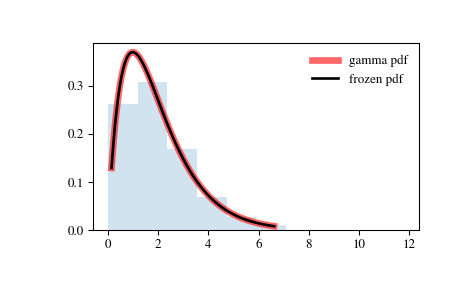

In [64]:
from scipy.stats import gamma

parametersSVM = {
    'C':gamma(a=1.0, loc=0, scale=0.001)
}

(tiempo_random_SVM, grid_svm) = correr_randomized_y_mostrar(
    LinearSVC(),
    parametersSVM,
    5,
    5,
    30
)

verTiempo(tiempo_SVM, tiempo_random_SVM)

Top 5 combinaciones


,C,mean_score_validation,mean_score_training
17,0.0007,0.8464,0.9480
11,0.0008,0.8457,0.9505
13,0.0007,0.8454,0.9454
12,0.0007,0.8454,0.9456
19,0.0007,0.8451,0.9448


Bot 5 combinaciones


,C,mean_score_validation,mean_score_training
7,5.6749e-03,0.8202,0.9902
24,4.7824e-03,0.8213,0.9883
16,4.3986e-03,0.8233,0.9873
10,1.2540e-05,0.8245,0.8501
28,4.0281e-05,0.8291,0.8612


'########### Timepos ###########'

'original: 381.044149'

'random: 912.072659'

'diferencia: 531.028509'

Podemos observar que los peores valores obtenidos (si bien usan un C mas cercano al 0 que los mejores) tienden a overfittear el conjunto de train y a no performar tan bien en el de validacion. Esto es, estan tomando un hiperplano tal que permite tan pocas malclasificaciones que termina overfitteando al entrenar. 

Por otro lado, los mejores valores de C tienen score un poco mejor que los que teniamos en el experimento sin Random Search. Esto es, random search nos ayudo a encontrar valores que no estabamos teniendo en cuenta.

Hablando de los tiempos de ejecucion, estos tardaron mucho mas en el caso random. Esto es por las 30 iteraciones que le dimos (en comparacion a 7 valores que usamos en el experimento comun). Sin embargo comparando la escala es solo el doble de tiempo para casi 5 veces mas pruebas.

### LDA

Para este experimento tomamos de manera aleatoria la cantidad de componentes usada w

#### Experimento 1

In [65]:
parametersLDA_svd = {
    'solver'            :['svd'],
    'priors'            :priors,
    'n_components'      :randint(1, 300),
}

(tiempo_random_LDA_svd, random_lda_svd) = correr_randomized_y_mostrar(
    LDA(),
    parametersLDA_svd,
    5,
    5,
    30
)

verTiempo(tiempo_LDA_svd, tiempo_random_LDA_svd)

Top 5 combinaciones


,n_components,priors,solver,mean_score_validation,mean_score_training
0,230,"(0.8, 0.2)",svd,0.7462,0.9931
1,126,"(0.1, 0.9)",svd,0.7462,0.9931
28,31,"(0.8, 0.2)",svd,0.7462,0.9931
27,63,"(0.8, 0.2)",svd,0.7462,0.9931
26,70,"(0.5, 0.5)",svd,0.7462,0.9931


Bot 5 combinaciones


,n_components,priors,solver,mean_score_validation,mean_score_training
0,230,"(0.8, 0.2)",svd,0.7462,0.9931
27,63,"(0.8, 0.2)",svd,0.7462,0.9931
26,70,"(0.5, 0.5)",svd,0.7462,0.9931
25,56,"(0.9, 0.1)",svd,0.7462,0.9931
24,15,"(0.7, 0.3)",svd,0.7462,0.9931


'########### Timepos ###########'

'original: 6354.868889'

'random: 3061.363697'

'diferencia: 3293.505192'

En este caso nos pasa algo parecido a Naive Bayes. Si bien probamos con varios parametros, los scores siempre son iguales. Asumimos que es un bug de sklearn y no continuamos con este experimento. 

#### Experimento 2

In [66]:
parametersLDA = {
    "solver": ["lsqr", "eigen"],
    "priors": priors,
    "shrinkage": uniform(0.1, 0.9),
    "n_components": randint(1, 400)
}

(tiempo_random_LDA_lsqr_eigen, grid_lda) = correr_randomized_y_mostrar(
    LDA(),
    parametersLDA,
    5,
    10,
    10
)

verTiempo(tiempo_LDA_lsqr_eigen, tiempo_random_LDA_lsqr_eigen)

Top 10 combinaciones


,n_components,priors,shrinkage,solver,mean_score_validation,mean_score_training
0,121,"(0.7, 0.3)",0.7375,eigen,0.8467,0.9334
9,267,"(0.9, 0.1)",0.7153,lsqr,0.8460,0.9340
6,22,"(0.6, 0.4)",0.7501,lsqr,0.8438,0.9351
5,232,"(0.3, 0.7)",0.7134,lsqr,0.8407,0.9423
3,317,"(0.3, 0.7)",0.5995,eigen,0.8380,0.9566
8,349,"(0.6, 0.4)",0.5012,eigen,0.8378,0.9676
7,374,"(0.3, 0.7)",0.5624,eigen,0.8376,0.9607
4,212,"(0.6, 0.4)",0.4715,eigen,0.8356,0.9701
1,17,"(0.1, 0.9)",0.7915,eigen,0.8349,0.9130
2,100,"(0.9, 0.1)",0.3520,eigen,0.8211,0.9569


Bot 10 combinaciones


,n_components,priors,shrinkage,solver,mean_score_validation,mean_score_training
2,100,"(0.9, 0.1)",0.3520,eigen,0.8211,0.9569
1,17,"(0.1, 0.9)",0.7915,eigen,0.8349,0.9130
4,212,"(0.6, 0.4)",0.4715,eigen,0.8356,0.9701
7,374,"(0.3, 0.7)",0.5624,eigen,0.8376,0.9607
8,349,"(0.6, 0.4)",0.5012,eigen,0.8378,0.9676
3,317,"(0.3, 0.7)",0.5995,eigen,0.8380,0.9566
5,232,"(0.3, 0.7)",0.7134,lsqr,0.8407,0.9423
6,22,"(0.6, 0.4)",0.7501,lsqr,0.8438,0.9351
9,267,"(0.9, 0.1)",0.7153,lsqr,0.8460,0.9340
0,121,"(0.7, 0.3)",0.7375,eigen,0.8467,0.9334


'########### Timepos ###########'

'original: 1163625.385284'

'random: 721.832752'

'diferencia: 1162903.552532'

En este experimento podemos ver el potencial de usar la busqueda aleatoria en un espacio de parametros extenso. Usando una cantidad de **componentes** grande y **shrinkage** relativamente pequeno, el predictor da buenos resultados en tan solo unas pocas iteraciones. Ademas, esto lo hace en un tiempo aproximadamente 80 veces mas rapido que con la busqueda exhaustiva. Aun mas, la busqueda exhaustiva mira un subconjunto de los valores de los parametros utilizados, esto demuestra el potencial de **RandomizedSearch** para algunos casos.

## Ejercicio 4: 
### Diagnóstico Sesgo-Varianza. 

En este punto, se pide inspeccionar dos de sus mejores modelos encontrados hasta ahora: el mejor modelo de tipo árbol de decisión y el mejor de tipo SVM. Para ello:

1. Graficar curvas de complejidad para cada modelo, variando la profundidad en el caso de árboles, y el hiperparámetro C en el caso de SVM. Diagnosticar cómo afectan al sesgo y a la varianza esos dos hiperparámetros.
2. Graficar curvas de aprendizaje para cada modelo. En base a estas curvas, sacar conclusiones sobre si los algoritmos parecen haber alcanzado su límite, o bien si aumentar la cantidad de datos debería ayudar.
3. Construir un modelo RandomForest con 200 árboles. Explorar para qué sirve el hiperparámetro max_features y cómo afecta a la performance del algoritmo mediante una curva de complejidad. Explicar por qué creen que se dieron los resultados obtenidos. Por último, graficar una curva de aprendizaje sobre los parámetros elegidos para determinar si sería útil o no conseguir más datos (usar  grid search para encontrar una buena combinación de parámetros).  


**Atención**: Tener en cuenta que debemos seguir utilizando ROC AUC como métrica para estas curvas.

**ver**: http://scikit-learn.org/stable/modules/learning_curve.html#learning-curve

----
**EJERCICIO EXTRA:** Utilizar RandomizedSearchCV para explorar la performance del algoritmo de Gradient Boosting y comparar con los resultados obtenidos en el punto (c).


----

**Obs**: En este ejercicio nos falta comparar random forest y gradient boosting.



In [18]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve

def plot_learning_curve(estimator, title, X, y, cv=None):
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Roc Auc Score")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, train_sizes=np.linspace(.1, 1.0, 5))
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std  = np.std(train_scores, axis=1)
    test_scores_mean  = np.mean(test_scores, axis=1)
    test_scores_std   = np.std(test_scores, axis=1)
    
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()


def plot_validation_curve(estimator, X, y, param, paramRange, plotTitle, parametroName):
    train_scores, test_scores = validation_curve(
        estimator, X, y, param_name=param, param_range=paramRange,
        cv=5, scoring="roc_auc")
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std  = np.std(train_scores, axis=1)
    test_scores_mean  = np.mean(test_scores, axis=1)
    test_scores_std   = np.std(test_scores, axis=1)

    plt.title(plotTitle)
    plt.xlabel(parametroName)
    plt.ylabel("Roc Auc Score")
    lw = 2
    
    plt.semilogx(paramRange, train_scores_mean, label="Training score",
                 color="red", lw=lw)
    plt.fill_between(paramRange, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="red", lw=lw)
    plt.semilogx(paramRange, test_scores_mean, label="Cross-validation score",
                 color="blue", lw=lw)
    plt.fill_between(paramRange, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="blue", lw=lw)
    plt.legend(loc="best")
    plt.show()

### Primeras curvas de complejidad

Veamos como se comportan las curvas para los parametros de ambos estimadores.

**Nota:** Para el arbol de decision usamos el primero que habiamos probado ya que tiene mejor score.

### SVM

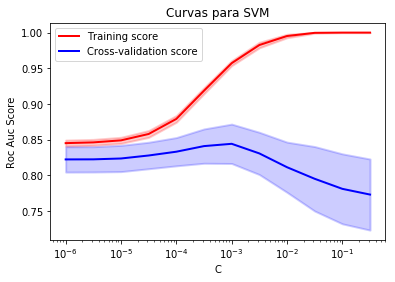

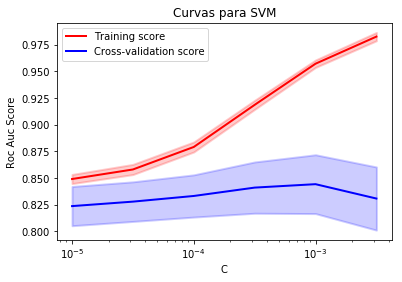

In [21]:
svm = grid_svm.best_estimator_
plot_validation_curve(svm,X_dev_np, y_dev_np, "C", [pow(10,x/2) for x in range(-12,0)],
                      "Curvas para SVM", "C")


plot_validation_curve(svm,X_dev_np, y_dev_np, "C", [pow(10,x/2) for x in range(-10,-4)],
                      "Curvas para SVM", "C")

En este gráfico se observa como el score de entrenamiento y validación se mantienen en un valor mas o menos constante hasta cierto punto en el que el primero comienza a mejorar bruscamente y el segundo decae. Recordemos que conforme aumenta C también aumenta el interes en ajustar el hiperplano de manera de mejorar la presición y no tanto en perseguir un posible hiperplano que maximice el margen de separación. Esto da lugar a un sobreajuste en el caso de que C se vuelva suficientemente grande, lo que produce que el modelo se construya sobra una hipotesis mas rígida y por ende se alcance un sesgo alto. En consecuencia si bien como resultado conseguimos un score de entrenamiento alto, por fruto del sobreajuste el score de validación se vuelve muy bajo. El mejor modelo parecería conseguirse con un C de aproximadamente 10^-3, en la que se consigue un buen score de entrenamiento, pero aun no se llega a sobreajustar, y el modelo mantiene una varianza decente y se maximiza el score de validación, que es lo que nos deja una pauta mas certera de como puede llegar a trabajar nuestro modelo en la realidad.

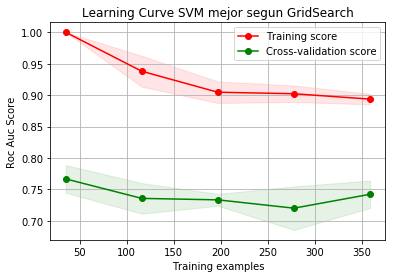

In [60]:
svm = grid_svm.best_estimator_
plot_learning_curve(svm, "Learning Curve SVM mejor segun GridSearch", X_dev_np, y_dev_np, cv=5)

Podemos ver en la curva de aprendizaje que no hay una tendencia tan marcada a mejorar la performance del modelo en validación, si no que mas bien decrece ligeramente. Esto último nos parece raro, sin embago a partir de aproximadamente las 275 muestras el modelo remonta un poco, lo que no nos deja una conclusion muy convincente si no mas bien la curiosidad ver que ocurriría si tuvieramos mas datos con los que entrenar.

### Decision Tree

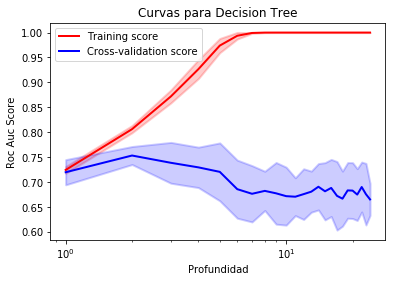

In [20]:
decisionTree = grid_decision_tree.best_estimator_
plot_validation_curve(decisionTree,X_dev_np, y_dev_np, "max_depth", range(1,25),
                      "Curvas para Decision Tree", "Profundidad")

Podemos observa como a medida que aumenta la profundidad del árbol aumentamos la performance en los datos de validación y por sobre todo la de los datos de entrenamiento. En un principio en donde ambas curvas son no decrecientes nos encontramos en una situación donde la profundidad no es tan grande y por lo tanto el sesgo tampoco lo es. Sin embargo a cierta profundidad el score en validacón decrece y comienza a ser mas erratico, en estas situación consideramos que nos encontramos en un escenario en la que la varianza es baja y el sesgo es muy alto. Esto también se evidencia en la alta performance que mantiene constante con respecto a los datos de entrenamiento, dando a entender que esta sobreajustando el modelo a ellos. Lo ideal parecería ser quedarnos con un árbol de altura entre aproximadamente 55 en donde el sesgo aun no crecio tanto y a su vez la varianza se mantiene en valores no tan chicos. 

#### Haciendo zoom

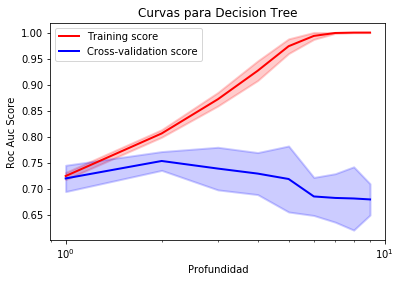

In [22]:
decisionTree = grid_decision_tree.best_estimator_
plot_validation_curve(decisionTree,X_dev_np, y_dev_np, "max_depth", range(1,10),
                      "Curvas para Decision Tree", "Profundidad")

Al realizar un zoom en los hiperparametros, podemos apreciar que la profundidad optima esta alrededor del 4. A partir de este valor se empieza a overfitear los datos de entrenamiento.

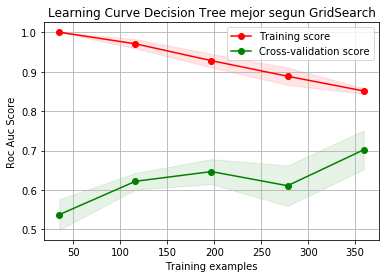

In [61]:
decisionTree = random_decision_tree_2.best_estimator_
plot_learning_curve(decisionTree, "Learning Curve Decision Tree mejor segun GridSearch", X_dev_np, y_dev_np, cv=5)

A diferencia de la curva de aprndizaje obtenida con SVM, en el caso del arbol de decision conseguimos un resultado mas alentador. Aqui se puede apreciar una tendencia mas contundente del score de validación y entrenamiento con respecto a la cantidad de datos utilizados. Esto nos lleva a sospechar fuertemente que podriamos llegar a conseguir un mejor modelo, tanto de mayor precision como de menor varianza, si tuvieramos mas datos con los que entrenar. Aunque como siempre bajo la suposicion de que estos datos sean representativos.

### Random Forest




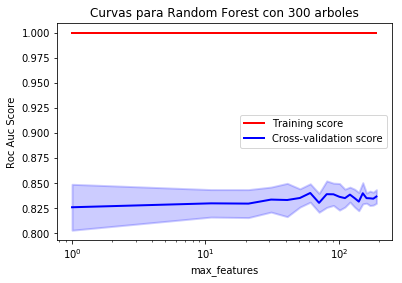

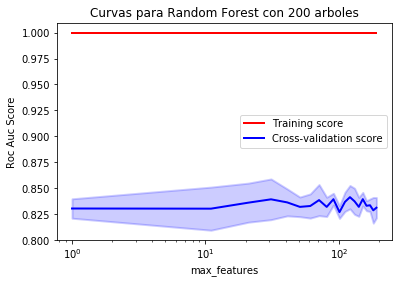

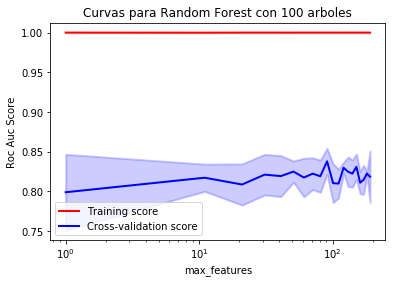

In [48]:
from sklearn.ensemble import RandomForestClassifier

plot_validation_curve(RandomForestClassifier(n_estimators=300),X_dev_np, y_dev_np,
                      "max_features", range(1,201,10),
                      "Curvas para Random Forest con 300 arboles", "max_features")

plot_validation_curve(RandomForestClassifier(n_estimators=200),X_dev_np, y_dev_np,
                      "max_features", range(1,201,10),
                      "Curvas para Random Forest con 200 arboles", "max_features")

plot_validation_curve(RandomForestClassifier(n_estimators=30),X_dev_np, y_dev_np,
                      "max_features", range(1,201,10),
                      "Curvas para Random Forest con 30 arboles", "max_features")

En esta ocasion nos dedicamos a jugar con el metodo de ensamble de Random Forest, el objetivo era generar un ensamble de 200 árboles, y luego experimentar el impacto que tenia en él ir variando el hiperparametro "max features". Este hiperparametro en teoría cumple la funcion de definir la cantidad de atributos distintos que son posibles seleccionar de manera aleatoria. Recordemos que los arboles de Random Forest son generados tomando en cuenta solo un subconjunto de los atributos de los cuales se basa para construir la estructura arboria, y asi intentar obtener arboles mas variados ignorando posibles atributos que tengan demasiado peso. Por ende nos econtramos con un tradeoff sobre este hiperparametro, si es demasiado chico los arboles generados se basan en muy poco atributos, lo que genera menos presicion en el modelo. Pero por otra parte si se tiene un "max features" demasiado alto, este tecnica se empieza a parecer a la tecnica de bagging, en el que teniamos el problema de tener muchos arboles similares.

Para poder tener un idea experimental de la relacion entre cantidad de árboles y la cantida de features maxima, decidimos generar la curva de complejidad correspondiente al caso de 30 y 300 árboles (además del caso pedido de 200). 
En cuanto a la cantidad de estimadores, por alguna razon de estos tres modelos no hay ninguno del cual podamos concluir a ciencia cierta que sea mucho mejor que los otros dos, es decir el resultado obtenido con 30 arboles del cual se esperaba no tener tanto score como en el 200, parece tener una performance similar. En lo correspondiente al hiperparametro "max_features" como es de esperarse, se consigue un mejor score a medida que este aumenta, aunque la mejora no es tan brusca como imaginabamos. Como era de esperarse para los tres modelos esta mejora para alguna cantidad de features permitidos (diferente para cada modelo) alcanza un valor en el que la varianza es muy alta y el score del modelo comienza a volverse erratico.

In [75]:
parametrosRF = {
    "max_features": ["sqrt", "log2", None] + [1, 20, 50, 100, 150, 200],
    "max_depth": [3, 6, 12],
    "min_samples_split": [2, 6, 12],
    "n_estimators": [10, 50, 120, 200]
}

(tiempo_random_forest, grid_random_forest) = correr_y_mostrar(
    RandomForestClassifier(),
    parametrosRF,
    5,
    5
)

randomForest = grid_random_forest.best_estimator_
plot_learning_curve(randomForest, "Learning Curve Random Forest Mejor segun GridSearch", X_dev_np, y_dev_np, cv=5)

KeyboardInterrupt: 

En cuanto al aprendizaje del modelo en relación al volumen del conjunt de entrenamiento, lo primero que observamos es que el score de validación no mantiene una tendencia optimista hasta el final, como si ocurre en otros casos. Aqui se obtiene un marcado crecimiento hasta llegar a las 100 muestras, luego esta tendencia comienza a decaer, por lo que acompañado del hecho de que el score en entrenamiento se mantiene constante, resulta que la evidencia se nos muestra pesimista sobre que el aumentar el tamaño de nuestro dataset nos vaya a dar alguna mejoria, tanto con respecto a la precision del modelo como a la varianza del mismo. 

### Gradient boosting

Top 5 combinaciones


,criterion,learning_rate,loss,max_depth,max_features,min_samples_split,n_estimators,subsample,mean_score_validation,mean_score_training
12,friedman_mse,0.1636,exponential,3,sqrt,2,128,0.9,0.8506,1.0
41,friedman_mse,0.8182,exponential,3,100,2,147,1.0,0.8479,1.0
6,friedman_mse,0.1273,exponential,6,50,6,147,0.3,0.8471,1.0
14,mse,0.1273,deviance,12,150,6,58,0.8,0.8452,1.0
19,mse,0.3636,deviance,3,150,2,164,1.0,0.8448,1.0


Bot 5 combinaciones


,criterion,learning_rate,loss,max_depth,max_features,min_samples_split,n_estimators,subsample,mean_score_validation,mean_score_training
35,friedman_mse,0.9000,deviance,12,log2,6,34,0.5,0.5462,0.7238
10,friedman_mse,0.5182,deviance,3,sqrt,6,180,0.3,0.5885,0.6089
22,friedman_mse,0.4818,deviance,3,sqrt,2,42,0.3,0.6249,0.8689
34,mse,0.5545,deviance,6,20,6,12,0.3,0.6315,0.8676
33,friedman_mse,0.9727,deviance,12,log2,2,159,0.5,0.6681,0.9508


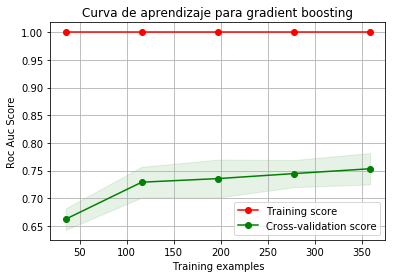

In [70]:
from sklearn.ensemble import GradientBoostingClassifier

parametrosGB = {
    "loss": ['deviance', 'exponential'],
    "criterion": ['mse', 'friedman_mse'],
    "learning_rate": np.linspace(0.1,1,100),
    "max_features": ["sqrt", "log2", None] + [1, 20, 50, 100, 150, 200],
    "max_depth": [3, 6, 12],
    "min_samples_split": [2, 6, 12],
    "subsample": [0.3, 0.5, 0.8, 0.9, 1.0],
    "n_estimators": range(1,200)
}
(tiempo_gb, random_grid_gb) = correr_randomized_y_mostrar(
    GradientBoostingClassifier(), 
    parametrosGB, 
    5, 
    5, 
    50
)

plot_learning_curve(
    random_grid_gb.best_estimator_, 
    "Curva de aprendizaje para gradient boosting",
    X_dev_np, 
    y_dev_np, 
    cv=5
)

Este algoritmo parece ser uno de los mas prometedores, asi que probamos con muchas combinaciones de hiperparametros esperando obtener un score en validacion notablemente mas alto que en los algoritmos anteriores. Si bien efectivamente conseguimos el score mas alto con respecto a los otros algorimos, no llegamos a conseguir una diferencia tan significativa con respecto a otros. Observando la curva de aprendizaje sospechamos que aumentar la cantidad de datos podría llegar a mejorar un poco la performance, pero no parece haber una tendencia de crecimiento tan marcada del score de validacion como para estar muy convencidos de obtener una mejora muy notable.

Al comparar este algotimo con el de Random Forest en relacion al mejor score conseguido en validacion, que hay una ligera diferencia a favor de Gradient Boosting, pero no es tan marcada y sospechamos que puede deberse a que en este último probamos muchas mas variantes de hiperparametros, por lo que quizas con una busqueda mas exautiva en el caso de Random Forest podría habernos dado la misma performance. Con respecto a su comportamiento con respecto al crecimiento del conjunto de entrenamiento, podemos ver en base a los graficos de ambas curvas de aprendizaje, sospechamos que Random Forest no se favorecería con el aumento del conjunto de entrenamiento, pues parece que se estanca en rapido con un conjunto mas reducido. En cambio con Gradient Boosting, su creciemiento del score de validación parece mas alentador, dandonos la sospecha que en este caso si podría mejorar con mas muestras, aunque como ya dijimos no necesariamente signifique que podamos llegar a conseguir un score mucho mayor.

## Competencias

La entrega del trabajo estará acompañada de una competencia en la cual deberán poner a prueba su mejor modelo y sobre todo, su capacidad para estimar sus resultados. 

Su tarea será estimar la performance (AUC ROC) que tendrá su mejor modelo en datos de evaluación (X_competencia). 

Para ello, deberán predecir las probabilidades de las distintas instancias con su modelo, enviarnos dichas probabilidades junto a una estimación con 4 decimales de cuál será el AUC ROC resultante y calcularemos el resultado real. El grupo que consiga acercarse más al valor real, será el grupo ganador.  

Recomendamos no perder de vista esta competencia en el momento de separar los datos en los primeros puntos. 

Para esto, junto con la entrega del informe, deberán enviar un archivo en formato csv con las columnas “index” y “output” (ver ejemplo de archivo en: [y_competencia_ejemplo.csv](https://github.com/pbrusco/aa-notebooks/blob/master/TP1/y_competencia_ejemplo.csv)) y un valor esperado de AUC ROC. 


## Entrega
- Contarán con un esqueleto en formato Jupyter Notebook en donde tendrán que completar las celdas faltantes (ya sea con explicaciones y gráficos o código). 
- El notebook final deberá ser entregado en formatos .html e .ipynb. Es necesario que los resultados puedan reproducirse al ejecutar todas las celdas en orden (Kernel - Restart and Run All) utilizando las bibliotecas requeridas en el archivo: requirements.txt del repositorio. 
- Tienen tiempo hasta las 23:59hs del día miércoles 17/10/2018. La entrega se debe realizar a través del campus virtual y debe contener el informe.
- El trabajo deberá elaborarse en grupos de 3 personas.
- Se podrán pedir pruebas de integridad y autoría; es decir, verificar que la salida solicitada es fruto del modelo presentado y que el modelo fue construido según lo requerido en este enunciado.
- La evaluación será grupal y se basará en la calidad del informe (presentación, claridad, prolijidad); la originalidad, practicidad y coherencia técnica de la solución; la corrección y solidez de las pruebas realizadas.
- En el primer parcial se incluirá una pregunta sobre la solución entregada. Esa pregunta no influirá en la nota del parcial, pero sí en la nota individual del TP1.
- La participación en la competencia es obligatoria. De todas maneras, el resultado no incidirán en la nota de la materia.
- Los ejercicios extra son opcionales para aprobar el TP, pero son obligatorios para promocionar la materia.
